In [ ]:
#!pip install catboost

In [1]:
# Import Packages
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import pickle
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
import catboost
from catboost import * 
import json

#  Загрузка датасетов и выделение Target

In [ ]:
with open('skillbox_diploma_main_dataset_sberautopodpiska/ga_hits.pkl', 'rb') as f:
    data1 = pickle.load(f)
    
with open('skillbox_diploma_main_dataset_sberautopodpiska/ga_sessions.pkl', 'rb') as f:
    data2 = pickle.load(f)

In [ ]:
# Список целевых действий

target_action =  ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click'] 

# Создаем target
data1['target'] = data1['event_action'].apply(lambda x: 1 if (x in target_action) else 0)

In [ ]:
# Групперуем по 'target' и 'session_id'
data_group = data1.groupby(['target', 'session_id']).size().reset_index(name='count')

# Оставим только значемые действия за один визит
data_group.drop_duplicates(subset = 'session_id', keep = 'last', inplace = True)

# Сзодаём нужный датасет с целевой переменной
df = pd.merge(data2, data_group[['session_id', 'target']], on='session_id', how='left')
df.shape

In [ ]:
df.dropna(inplace=True, subset='target') # удаляем объекты у которых target не определён
df.to_csv('data.csv', index=False, header=True) # созраняем датасет для работы в скрипте

# Data Preparation

In [4]:
# df = pd.read_csv("data.csv")

In [5]:
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0


In [6]:
# избавимся от неимформотивных колонок и сохраним в новый датасет
df.drop(columns=['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number'], inplace=True)

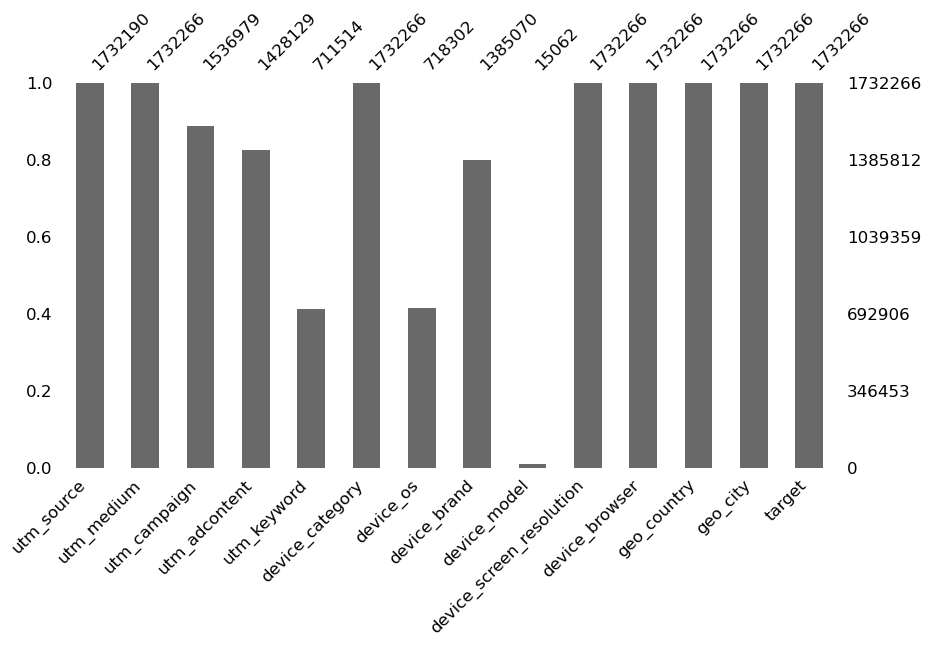

In [7]:
# Выведем проценты пропущенных значений
msno.bar(df, figsize=(10,5), fontsize=12);

In [8]:
df.drop(columns=['device_model'], inplace=True) # удаляем недееспособный признак

df.drop_duplicates(inplace=True, ignore_index=True) #ураляем дубликаты

In [9]:
# выведем количество полностью заполненных объектов
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 131479
Процент полностью заполненных объектов из всей выборки: 31.94


In [10]:
# Выведем процент пропцщенных в каждой колонке
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(key=lambda x: -x)
missing_values = missing_values[missing_values > 0]
print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


utm_keyword      51.139535
device_os        50.561934
device_brand     21.860662
utm_adcontent    19.134910
utm_campaign     10.809734
utm_source        0.009473
dtype: float64

In [11]:
# Переведем разрешение экрана в числовой признак
device_screen = df['device_screen_resolution'].apply(lambda x:  int(x.split('x')[0]) * int(x.split('x')[1] if x != '(not set)' else 0))
df['device_screen_resolution'] = device_screen

In [12]:
# Заполним пропуски в категориальных переменных модой
imputer = SimpleImputer(strategy = 'most_frequent')

for i in df.columns:
    if (i != 'device_screen_resolution') and (i != 'target'):
        df[i] = imputer.fit_transform(df[i].values.reshape(-1,1))[:,0]

In [13]:
# Заполним пропуски в категориальных переменных модой
imputer = SimpleImputer(missing_values=None, strategy = 'most_frequent')

for i in df.columns:
    if (i != 'device_screen_resolution') and (i != 'target'):
        df[i] = imputer.fit_transform(df[i].values.reshape(-1,1))[:,0]

Text(0.5, 1.0, 'Рапределение целевых переменных в датасете')

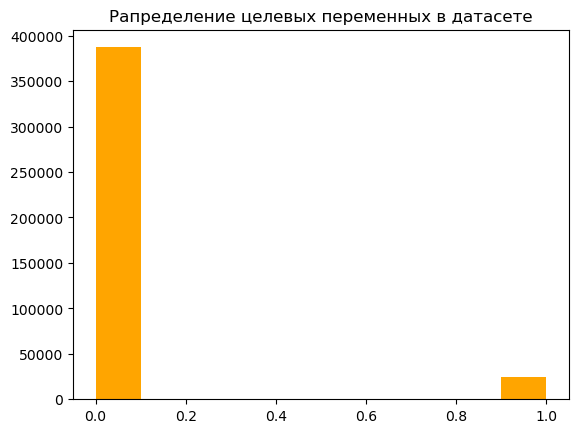

In [37]:
plt.hist(df.target, color='orange')
plt.title("Рапределение целевых переменных в датасете");

**Видим, что датасет несбалансирован, это нужно иметь ввиду когда будем поодбирать алгоритмы машинного обучения!**

# Data Cleaning

Посмотрим на выбросы в признаке 'device_screen_resolution'

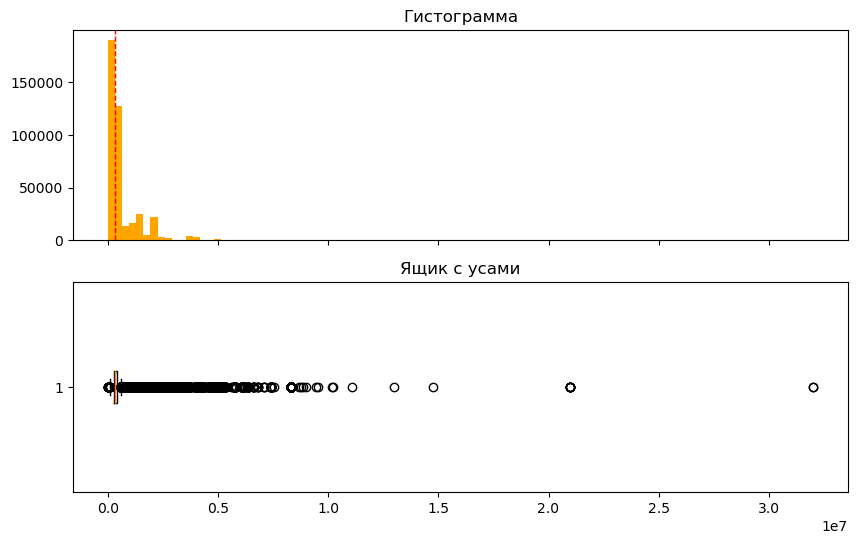

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

ax1.hist(df.device_screen_resolution, bins=100, color='orange')
ax1.set_title('Гистограмма')
ax1.axvline(df.device_screen_resolution.median(), color='red', linestyle='dashed', linewidth=1)

ax2.boxplot(df.device_screen_resolution, vert=False)
ax2.set_title('Ящик с усами');

In [15]:
#Найти пороги для отнесения значения к выбросам
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

q = calculate_outliers(df.device_screen_resolution)
# процент выбросов относительно общего количества записей в датасете
(len(df[df.device_screen_resolution < q[0]]) + len(df[df.device_screen_resolution > q[1]]))/ len(df) * 100

23.136581467708517

In [16]:
# Избавляемся от выбросов в device_screen_resolution

# заменим нижние выбросы на нижнее пороговое значение
df.device_screen_resolution[df.device_screen_resolution < q[0]] = df.device_screen_resolution[df.device_screen_resolution < q[0]].apply(lambda x: q[0])

# заменим верхние выбросы на верхнее пороговое значение
df.device_screen_resolution[df.device_screen_resolution > q[1]] = df.device_screen_resolution[df.device_screen_resolution > q[1]].apply(lambda x: q[1])

In [17]:
# Стандартизируем 'device_screen_resolution'
scaler = StandardScaler()

df['device_screen_resolution'] = scaler.fit_transform(df[['device_screen_resolution']])
df

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Zlatoust,0.0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,-0.314273,Samsung Internet,Russia,Moscow,0.0
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Krasnoyarsk,0.0
3,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0
4,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732257,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,-0.613044,Android Webview,Russia,Saint Petersburg,1.0
1732258,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,-0.320529,Chrome,Russia,Birsk,0.0
1732259,ISrKoXQCxqqYvAZICvjs,blogger_stories,zfwIehuEfWYdYrEZgRLo,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,-0.005512,Safari,Russia,Zheleznodorozhny,0.0
1732260,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,-1.138071,Chrome,Russia,Naro-Fominsk,0.0


# Feature Engineering

Добавим признак `'capital'` который означает столица ли этот город, и `'subscription'` который значит что в этом городе действует подписка

In [18]:
all_cities = ['moscow', 'krasnogorsk', 'podolsk', 'khimki', 'mytishchi', 'balashikha', 'zheleznodorozhny', 'lyubertsy', 
              'korolev', 'krasnoarmeysk', 'elektrostal', 'orekhovo-zuevo', 'noginsk', 'sergiev posad', 'dmitrov', 'pushkino', 
              'ivanteevka', 'domodedovo', 'lobnya', 'klin', 'ramenskoye', 'shchyolkovo', 'odintsovo', 'vidnoye', 'reutov', 
              'tuchkovo', 'chekhov', 'dolgoprudny', 'zelenograd', 'khimki', 'pavlovsky posad', 'solnechnogorsk', 'shatura', 
              'khimki', 'krasnogorsk', 'naro-fominsk', 'orekhovo-zuevo', 'taldom', 'zvenigorod', 'kolomna', 'lytkarino', 
              'ramenskoye', 'serpukhov', 'dubna', 'pushkino', 'krasnoznamensk', 'kubinka', 'elektrogorsk', 'istra', 'ruzayevka',
              'klimovsk', 'voskresensk', 'volokolamsk', 'zhukovsky', 'kotelniki', 'losino-petrovsky', 'zvyozdny gorodok', 
              'shakhovskaya', 'saint petersburg', 'vyborg', 'gatchina', 'kronshtadt', 'sosnovy bor', 'priozersk', 'lomonosov',
              'podporozhye', 'sertolovo', 'volkhov', 'tikhvin', 'kirishi', 'kolpino', 'vsevolozhsk', 'sestroretsk', 'kirovsk', 
              'vyborg', 'pushkin', 'petergof', 'kingisepp', 'luga', 'slantsy', 'tosno', 'shlisselburg', 'boksitogorsk', 
              'pikalyovo', 'novaya ladoga', 'tikhvin', 'ivangorod', 'svetogorsk', 'sebezh', 'shakhovskaya']

In [19]:
# если город это столица, то 1
df['capital'] = df['geo_city'].apply(lambda x: 1 if (x.lower() == 'moscow') else 0)

# если в городе есть СберАвтоподписка, то 1
df['subscription'] = df['geo_city'].apply(lambda x: 1 if (x.lower() in all_cities) else 0)

In [20]:
df.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,capital,subscription
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Zlatoust,0.0,0,0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,-0.314273,Samsung Internet,Russia,Moscow,0.0,1,1
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Krasnoyarsk,0.0,0,0
3,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1
4,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1


In [21]:
df.nunique()

utm_source                   280
utm_medium                    55
utm_campaign                 406
utm_adcontent                280
utm_keyword                 1192
device_category                3
device_os                     13
device_brand                 200
device_screen_resolution    2841
device_browser                55
geo_country                  159
geo_city                    2389
target                         2
capital                        2
subscription                   2
dtype: int64

## Закодируем категориальные переменные.

### geo_city

Так как уникальных значений много используем `Geographical Encoding`

In [23]:
df_cat = df.copy() # Сохраним датасет для CatBoost который умеет работать с категориальными переменными

In [21]:
!pip install geocoder

In [61]:
import geocoder

geo_code = {}

for i in df.geo_city.unique():
    if i != '(not set)':
        geo_code[i] = (geocoder.osm(i).lat, geocoder.osm(i).lng)
    else:
        geo_code[i] = (-91, -181)
geo_code

{'Zlatoust': (55.1674213, 59.6792625),
 'Moscow': (55.7504461, 37.6174943),
 'Krasnoyarsk': (56.0090968, 92.8725147),
 'Saint Petersburg': (27.7700475, -82.6359078),
 'Sochi': (43.5854823, 39.723109),
 'Yaroslavl': (57.6263877, 39.8933705),
 'Mytishchi': (55.9094928, 37.7339358),
 '(not set)': (-91, -181),
 'Novorossiysk': (44.7239578, 37.7690711),
 'Balashikha': (55.8036225, 37.9646488),
 'Pushkino': (56.0104274, 37.8461892),
 'Vladivostok': (43.1150678, 131.8855768),
 'Alexandrov': (56.3962287, 38.7111103),
 'Astrakhan': (46.3498308, 48.0326203),
 'Sunny Isles Beach': (25.9426915, -80.1218486),
 'Reutov': (55.7622453, 37.856555),
 'Kazan': (55.7823547, 49.1242266),
 'Ulyanovsk': (54.3107593, 48.3642771),
 'Tula': (40.732465, 8.983921),
 'Yekaterinburg': (56.839104, 60.60825),
 'Rostov-on-Don': (47.2216548, 39.7096061),
 'Samara': (53.198627, 50.113987),
 'Domodedovo': (55.40912105, 37.904166212415895),
 'Yoshkar-Ola': (56.6328248, 47.8972462),
 'Chelyabinsk': (55.1598408, 61.4025547)

In [97]:
# # Сохраняем geo_code, для того чтобы потом снова не тратить много времение на кодирование
# with open('geo_code.json', 'w') as file:
#     json.dump(geo_code, file)

In [22]:
# # Считываем годовый geo_code
# with open('geo_code.json', 'r') as file:
#     # Загружаем данные из файла в словарь
#     geo_code = json.load(file)

In [23]:
# Получаем значения широты и долготы городов
df['latitude'] = df['geo_city'].apply(lambda x: geo_code[x][0] if geo_code[x][0] != None else -91)
df['longitude'] = df['geo_city'].apply(lambda x: geo_code[x][1] if geo_code[x][1] != None else -181)

df.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,capital,subscription,latitude,longitude
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Zlatoust,0.0,0,0,55.167421,59.679263
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,-0.314273,Samsung Internet,Russia,Moscow,0.0,1,1,55.750446,37.617494
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Krasnoyarsk,0.0,0,0,56.009097,92.872515
3,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1,55.750446,37.617494
4,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1,55.750446,37.617494


In [24]:
# Стандартизируем 'latitude' и 'longitude'
scaler = StandardScaler()

df['latitude'] = scaler.fit_transform(df[['latitude']])
df['longitude'] = scaler.fit_transform(df[['longitude']])

df.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,capital,subscription,latitude,longitude
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Zlatoust,0.0,0,0,0.373645,0.659152
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,-0.314273,Samsung Internet,Russia,Moscow,0.0,1,1,0.391016,0.326987
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Krasnoyarsk,0.0,0,0,0.398722,1.158914
3,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1,0.391016,0.326987
4,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1,0.391016,0.326987


In [25]:
df.drop(columns='geo_city', inplace=True) # удалим ненужную колонку

### utm_keyword

In [26]:
df.utm_keyword.value_counts() # из-за того что в самом начале было 51 процентов пропусков, теперь нерациональное распределение

puhZPIYqKXeFPaUviSjo    315814
aXQzDWsJuGXeBXexNHjc      4400
ITfrGJNwVsHBGJMAKoct      3411
UKNBOHebRIIsQRsjNKay      3096
pHqgLcdBQPSLcrTpLkdr      2727
                         ...  
NLWjXuYiXlKrFJfSWfKt         1
pvCdohkUBGPPZOsCzVAu         1
fCNPAcbVPCfuNeiACAQI         1
pXkDvQhCnVadSnzdyZWz         1
fcXWTQaKfxbkBkBnzLhK         1
Name: utm_keyword, Length: 1192, dtype: int64

In [27]:
df.drop(columns='utm_keyword', inplace=True) # удалим эту колонку

### Используем OHE кодирование для остальных колонок

| Колонка | Количество уникальных значений |
| --- | --- |
|utm_source     |  280|
|utm_medium     |  55|
|utm_campaign   |  406|
|utm_adcontent  |  280|
|device_category|    3|
|device_os      |   13|
|device_brand   |  200|
|device_browser |   55|
|geo_country    |  159|

In [30]:
categorical_features = df.select_dtypes(include='object').columns

# Создаем экземпляр OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Проходим по каждому категориальному признаку и выполняем OHE кодирование
encoded_features = encoder.fit_transform(df[categorical_features])

# Создаем DataFrame из закодированных признаков
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(categorical_features))

# Присоединяем новые переменные к исходному датафрейму
df_new = pd.concat([df, encoded_df], axis=1)

# Удаляем исходные категориальные признаки из исходного датафрейма
df_new.drop(categorical_features, axis=1, inplace=True)

Часть кода для сокращения обучающей выборки и её сохранения

In [32]:
# # Уменьшим количество объектов, для умещения в память
# df_new = pd.concat([df_new[df_new.target == 0].sample(frac=0.5), df_new[df_new.target == 1]], axis=0, ignore_index=True)

# df_new = df_new.sample(frac=1).reset_index() # перемешаем датасет

In [ ]:
# # Сохраним обработанный датасет для предстказаний модели
# df_new.to_csv('data2.csv', index=False, header=True)

# CatBoost

In [25]:
df_cat.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,capital,subscription
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Zlatoust,0.0,0,0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,-0.314273,Samsung Internet,Russia,Moscow,0.0,1,1
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,-0.823992,Chrome,Russia,Krasnoyarsk,0.0,0,0
3,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1
4,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,-0.459974,Chrome,Russia,Moscow,0.0,1,1


In [24]:
X = df_cat.drop('target', axis=1)
y = df_cat['target']

In [26]:
# найдём номера категориальных переменных
obj_columns = df_cat.select_dtypes(include='object').columns

cat_features = [i for i in range(len(df_cat.columns)) if df_cat.columns[i] in obj_columns]

print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

# Cross-validation

Так как выборка несбалансирована stratified=True

In [28]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'custom_loss': 'AUC',
    'random_seed': 63,
    'learning_rate': 0.3,
    'early_stopping_rounds': 10,
    'eval_metric': 'AUC',
    'depth': 7,
}

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7685241642
bestIteration = 126

Training on fold [1/5]

bestTest = 0.7730961856
bestIteration = 236

Training on fold [2/5]

bestTest = 0.7662281897
bestIteration = 122

Training on fold [3/5]

bestTest = 0.7673770671
bestIteration = 201

Training on fold [4/5]

bestTest = 0.773441356
bestIteration = 177



In [30]:
cv_data.tail()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
242,242,0.769591,0.003351,0.196488,0.000820,0.189200,0.002208
243,243,0.769585,0.003344,0.196489,0.000818,0.189196,0.002214
244,244,0.769579,0.003337,0.196491,0.000814,0.189191,0.002221
245,245,0.769586,0.003346,0.196491,0.000814,0.189179,0.002240
246,246,0.769593,0.003354,0.196490,0.000817,0.189175,0.002246


## CatBoostClassifier

In [32]:
model=CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.3,
    early_stopping_rounds=20,
    custom_loss=['F1', 'Accuracy']
)

model.fit(
    X_train,y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
model.best_score_

{'learn': {'Accuracy': 0.9408311125916056,
  'F1': 0.013879250520471894,
  'Logloss': 0.19192222614025778},
 'validation': {'Accuracy': 0.940653059241687,
  'F1': 0.0056848944233892805,
  'Logloss': 0.19659025789214207,
  'AUC': 0.7703745600977108}}

In [34]:
model.get_feature_importance(prettified=True) # посмотрим на важность фичей

,Feature Id,Importances
0,utm_campaign,16.893951
1,device_screen_resolution,12.745651
2,utm_medium,12.657705
3,geo_city,10.614489
4,device_brand,8.386213
5,utm_source,7.874055
6,device_browser,6.719957
7,utm_keyword,5.463439
8,utm_adcontent,4.575834
9,geo_country,3.468083


Визуализация ROC кривой

In [35]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

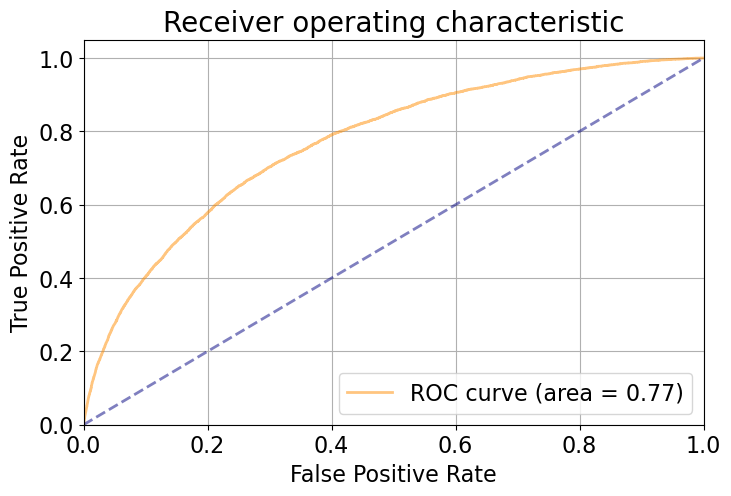

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

## Базовые методы Машинного обучения

In [2]:
# df_new = pd.read_csv("data2.csv")

In [8]:
X = df_new.drop(columns=['index', 'target'], axis=1)
y = df_new['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)

In [9]:
models = [
    LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
    RandomForestClassifier(class_weight='balanced', random_state=42),
    SVC(class_weight='balanced', random_state=42)
]

In [ ]:
best_score = .0
best_model = None

for model in models:
    score = cross_val_score(model, X, y, cv=4, scoring='roc_auc') # Проведём кросс-валидацию и отберем лучшую модель
    print(f'model: {model}, roc_auc: {score}') 

    if score.mean() > best_score:
        best_score = score
        best_model = model
        
print(best_model)